In [1]:
import pandas as pd
import re
import json
import numpy as np
import nltk
import jieba as jb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
label_list = [0,1,2,3,4,5,6,7,8,9]
lst_dics = []

with open('./train_data.txt','r') as f:
    for line in f:
        text = line.strip()
        dd = json.loads(text)
        lst_dics.append(dd)    

print(lst_dics[0])

{'label': 0, 'raw': "I only watched the Wanda Sykes portion of this show. I think it was interesting to watch because it was before she came out as a lesbian. She was married to a man at the time. She actually made some jokes that raised my eyebrows since she is now a lesbian. I didn't like this because it seemed hypocritical but I think Wanda Sykes is really funny. She is one of the few comedians who can make me really LOL (Laugh Out Loud). If you want to see what her comedy was like before she came out a lesbian or you are a Wanda Sykes fan, watch it. I am a huge fan of hers. I would like to see her in a live how. I am glad she is true to herself now and came out as a lesbian. I hope Wanda keeps on making me and others laugh for a long time to come."}


In [3]:
# 用dataframe将字符串列表转化为表格
df = pd.DataFrame(lst_dics)

df.sample(5)

,label,raw
4331,5,Although the book jacket suggested the storyli...
225,0,Journeyman looks to be another series with pro...
7929,9,"Obviously, from all the other reviews posted h..."
7203,9,This is not another lousy Celtic New Age album...
2469,3,My sister had a Diaper Genie and it always sme...


In [4]:
# 查看是否有空值，并统计各类别下的文本数量
df['label'].isnull().sum()
df['raw'].isnull().sum()
df[df.isnull().values == True]
df = df[pd.notnull(df['raw'])]

d = {'label': df['label'].value_counts().index, 'count': df['label'].value_counts() }
_label = pd.DataFrame(data=d).reset_index(drop=True)
_label

,label,count
0,0,800
1,1,800
2,2,800
3,3,800
4,4,800
5,5,800
6,6,800
7,7,800
8,8,800
9,9,800


In [5]:
# 加载停用词
stopwords = nltk.corpus.stopwords.words("English")

# 删除非字母、数字、空格以外的所有符号
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile("[^0-9a-zA-Z\s-]")
    line = rule.sub('', line).strip()
    return line

df['clean_raw'] = df['raw'].apply(remove_punctuation)
df.sample(5)

,label,raw,clean_raw
3277,4,This is another product I've used for years to...,This is another product Ive used for years to ...
2872,3,"I considered this when it was full price, 50 b...",I considered this when it was full price 50 bu...
5865,7,The Plantronics 510 is comfortable to wear for...,The Plantronics 510 is comfortable to wear for...
7019,8,These T shirts are thin (which I personally li...,These T shirts are thin which I personally lik...
4969,6,"&quot;Peter Pan&quot;, the 2nd Disney Classic ...",quotPeter Panquot the 2nd Disney Classic that ...


In [6]:
# 分词，并过滤停用词
df['cut_raw'] = df['clean_raw'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86137\AppData\Local\Temp\jieba.cache
Loading model cost 0.927 seconds.
Prefix dict has been built successfully.


,label,raw,clean_raw,cut_raw
0,0,I only watched the Wanda Sykes portion of this...,I only watched the Wanda Sykes portion of this...,I watched Wanda Sykes portion ...
1,0,"This is a cute series, and I did watch two epi...",This is a cute series and I did watch two epis...,This cute series I watch two...
2,0,This series revolves around 4 friends who run ...,This series revolves around 4 friends who run ...,This series revolves around 4 friend...
3,0,"I was pleasantly surprised with this ""out of t...",I was pleasantly surprised with this out of th...,I pleasantly surprised box ...
4,0,I heard about It's Always Sunny from a Kevin S...,I heard about Its Always Sunny from a Kevin Sm...,I heard Its Always Sunny Kevin...


In [7]:
# LSTM建模
# 设置最频繁使用的50000个词(在texts_to_matrix是会取前MAX_NB_WORDS列)
MAX_NB_WORDS = 50000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cut_raw'].values)
word_index = tokenizer.word_index
'词库共有 %s 个单词.' % len(word_index)

'词库共有 41023 个单词.'

In [8]:
X = tokenizer.texts_to_sequences(df['cut_raw'].values)
# 填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# 多类标签的onehot展开
Y = pd.get_dummies(df['label']).values
print(X.shape)
print(Y.shape)

(8000, 250)
(8000, 10)


In [9]:
# 拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(7600, 250) (7600, 10)
(400, 250) (400, 10)


In [10]:
# 定义模型
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_list), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 200)          10000000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 200)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 10)                2010      
                                                                 
Total params: 10,322,810
Trainable params: 10,322,810
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 模型训练
epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test, Y_test)
'Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1])


Epoch 1/10
54/54 [==============================] - 179s 3s/step - loss: 2.0949 - accuracy: 0.2629 - val_loss: 1.6228 - val_accuracy: 0.3829
Epoch 2/10
54/54 [==============================] - 239s 4s/step - loss: 1.1492 - accuracy: 0.5854 - val_loss: 0.6858 - val_accuracy: 0.7697
Epoch 3/10
54/54 [==============================] - 262s 5s/step - loss: 0.4236 - accuracy: 0.8635 - val_loss: 0.5092 - val_accuracy: 0.8145
Epoch 4/10
54/54 [==============================] - 269s 5s/step - loss: 0.2175 - accuracy: 0.9317 - val_loss: 0.3703 - val_accuracy: 0.8974
Epoch 5/10
54/54 [==============================] - 275s 5s/step - loss: 0.1447 - accuracy: 0.9624 - val_loss: 0.2860 - val_accuracy: 0.9184
Epoch 6/10
54/54 [==============================] - 273s 5s/step - loss: 0.1590 - accuracy: 0.9617 - val_loss: 0.2968 - val_accuracy: 0.9145
Epoch 7/10
54/54 [==============================] - 281s 5s/step - loss: 0.2152 - accuracy: 0.9516 - val_loss: 0.3442 - val_accuracy: 0.9026
Epoch 8/10
13

'Test set\n  Loss: 0.341\n  Accuracy: 0.892'

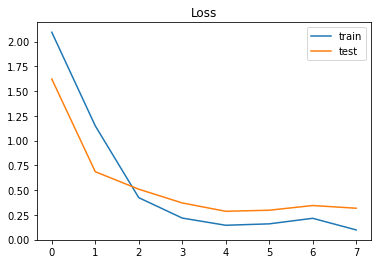

In [12]:
import matplotlib.pyplot as plt

# 绘制损失函数趋势图
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

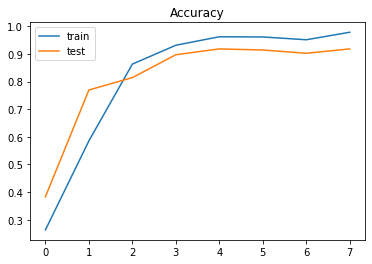

In [13]:
# 绘制精确率趋势图
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [14]:
# LSTM模型的评估
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
Y_test = Y_test.argmax(axis=1)

# 查看相应精度
'accuracy %s' % accuracy_score(y_pred, Y_test)
target_names = ['label 0','label 1','label 2','label 3','label 4','label 5',
                'label 6','label 7','label 8','label 9']
print(classification_report(Y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     label 0       0.97      0.76      0.85        42
     label 1       1.00      0.87      0.93        47
     label 2       0.93      0.87      0.90        45
     label 3       0.89      0.95      0.92        41
     label 4       0.89      0.94      0.92        35
     label 5       0.89      0.95      0.92        42
     label 6       0.69      0.85      0.76        34
     label 7       0.89      0.91      0.90        35
     label 8       0.88      0.92      0.90        39
     label 9       0.92      0.90      0.91        40

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.89      0.89       400



In [15]:
# 预测函数
def predict(text):
    txt = remove_punctuation(text)
    txt = [" ".join([w for w in list(jb.cut(txt.lower())) if w not in stopwords])]
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id = pred.argmax(axis=1)[0]
    return cat_id

predict("Considering this was shot in 1972 the video quality is excellent (4:3). Nice sharp (close-up) images with longer shots a little muddled as to be expected with only a few spotlights running during the show. Audio is in its original stereo and sounds OK to pretty good. The performance is stellar but a little short (64 Minutes). It's got a really cool trippy film section about half way through. Far-out. If you like the music of Traffic - get it while you can.")

6

In [16]:
id_list, text_list2 = [], []
with open('./test.txt', 'r') as test_f:
    lines = test_f.readlines()
    for line in lines:
        if line == 'id, text\n' or line == '':
            continue
        sep_index = line.find(',')
        id_list.append(int(line[0: sep_index]))
        text_list2.append(line[sep_index + 1:].strip())
test_data_df = pd.DataFrame({'id': id_list, 'text': text_list2})
test_data_df.sort_index()
test_data_df.head()

,id,text
0,0,Considering this was shot in 1972 the video qu...
1,1,"ok, I know its just random, but it seems like ..."
2,2,Have used this for 5 months and have seen a di...
3,3,This app is good but I uninstallled because th...
4,4,"Yes, I believe they got it right this time, to..."


In [17]:
pred_list = []
for i in id_list:
    pred_list.append(predict(test_data_df.iloc[i,1]))
    
test_data_df['pred'] = pred_list
test_data_df.head(10)

,id,text,pred
0,0,Considering this was shot in 1972 the video qu...,6
1,1,"ok, I know its just random, but it seems like ...",1
2,2,Have used this for 5 months and have seen a di...,4
3,3,This app is good but I uninstallled because th...,1
4,4,"Yes, I believe they got it right this time, to...",6
5,5,"The end that plugs into the device, it not at ...",7
6,6,I heard the book was better but I found the do...,0
7,7,"Years ago, when wrinkle development bothered m...",4
8,8,The title says it all. One of the very last M...,9
9,9,"Pros: The product looks very sleek, and is ver...",7


In [18]:
pred_df = pd.DataFrame({'id': id_list, 'pred': pred_list})
pred_df.head()

,id,pred
0,0,6
1,1,1
2,2,4
3,3,1
4,4,6


In [19]:
with open('./submit_sample.txt', 'w') as f_out:
    f_out.write('id, pred\n')
    for i in id_list:
        f_out.write(str(i)+ ', '+ str(pred_list[i]) +'\n')